In [1]:
library(tidyverse)
library(chron)

# Set preferences
Sys.setlocale("LC_TIME","C");
options(stringsAsFactors=FALSE)
options(chron.year.abb=FALSE)
theme_set(theme_bw()) # just my preference for plots

# Get working directory
getwd()

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


[1] "C"

[1] "/home/my_notebooks/Air_Pollution"

In [2]:
df <- readRDS("MAGLAUS/MAG-LAU.rds")
lf <- df %>%
 gather(variable, value,
 -c(site, datetime, season, year, month, day, hour, dayofwk, daytype))
lf$date <- dates(lf$datetime)

In [3]:
head(lf)

,site,datetime,year,month,day,hour,dayofwk,daytype,season,variable,value,date
,<chr>,<chron>,<ord>,<ord>,<ord>,<dbl>,<ord>,<chr>,<fct>,<chr>,<dbl>,<dates>
1,LAU,(01/01/2022 00:00:00),2022,Jan,1,0,Sat,Weekend,DJF,O3,7.9,01/01/2022
2,LAU,(01/01/2022 01:00:00),2022,Jan,1,1,Sat,Weekend,DJF,O3,2.4,01/01/2022
3,LAU,(01/01/2022 02:00:00),2022,Jan,1,2,Sat,Weekend,DJF,O3,17.7,01/01/2022
4,LAU,(01/01/2022 03:00:00),2022,Jan,1,3,Sat,Weekend,DJF,O3,9.7,01/01/2022
5,LAU,(01/01/2022 04:00:00),2022,Jan,1,4,Sat,Weekend,DJF,O3,17.0,01/01/2022
6,LAU,(01/01/2022 05:00:00),2022,Jan,1,5,Sat,Weekend,DJF,O3,4.3,01/01/2022


`summarise()` has grouped output by 'date', 'site', 'season'. You can override
using the `.groups` argument.
`summarise()` has grouped output by 'months(date)', 'years(date)', 'site',
'season'. You can override using the `.groups` argument.


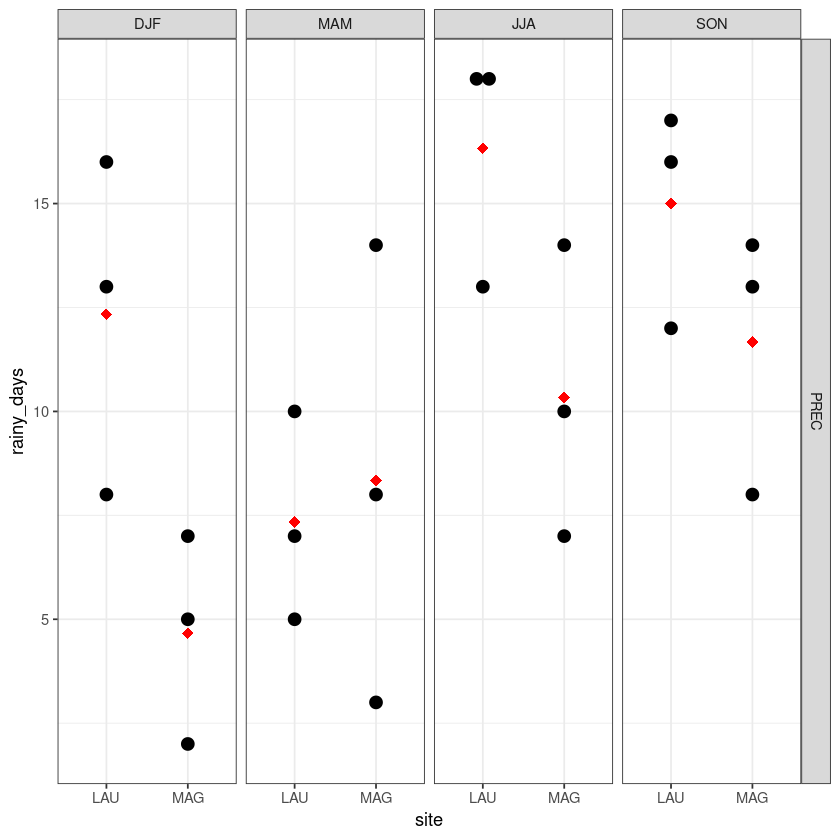

In [4]:
lf %>%
    filter(variable=="PREC" & !is.na(value)) %>%
    group_by(date, site, season, variable) %>%
    summarise(value = sum(value)) %>%
    group_by(months(date), years(date), site, season, variable) %>%
    summarise(mean_val = mean(value),
              rainy_days = sum(value>0),
              sum_val = sum(value),
              h_rainy_days = sum(value > 1)) %>%
ggplot +
    facet_grid(variable ~ season, scale = "free_y") +
    geom_dotplot(aes(x=site, y=rainy_days, group=site), binaxis='y', stackdir='center', binwidth=0.3)+
    stat_summary(aes(x=site, y=rainy_days), fun=mean, geom="point", shape=18,
             size=3, color="red")

In [5]:
dailyPrec <- lf %>%
  filter(variable=="PREC" & !is.na(value)) %>% # select variables
  mutate(date = as.character(dates(datetime))) %>%# get the date value
  mutate(rain.hour = value>0) %>%
  select(-c(datetime, date, hour, daytype, variable))%>%
  group_by(site, year, month, day, season) %>%
  summarise(prec.mean = mean(value),
            prec.sum = sum(value),
            rain.hours = sum(rain.hour),
            rain.day = sum(value)>0,
            recovery.percent = length(value)*100/24,
            recovery.numbers = length(value)) %>%
  ungroup()

`summarise()` has grouped output by 'site', 'year', 'month', 'day'. You can
override using the `.groups` argument.


In [6]:
head(dailyPrec)

site,year,month,day,season,prec.mean,prec.sum,rain.hours,rain.day,recovery.percent,recovery.numbers
<chr>,<ord>,<ord>,<ord>,<fct>,<dbl>,<dbl>,<int>,<lgl>,<dbl>,<int>
LAU,2022,Jan,1,DJF,0.0000000,0.0,0,FALSE,100,24
LAU,2022,Jan,2,DJF,0.0000000,0.0,0,FALSE,100,24
LAU,2022,Jan,3,DJF,0.0000000,0.0,0,FALSE,100,24
LAU,2022,Jan,4,DJF,0.2416667,5.8,9,TRUE,100,24
LAU,2022,Jan,5,DJF,0.5833333,14.0,6,TRUE,100,24
LAU,2022,Jan,6,DJF,0.0000000,0.0,0,FALSE,100,24


In [7]:
monthlyPrec <- dailyPrec %>%
    group_by(site, year, month, season) %>%
    summarize(daily.prec.mean = mean(prec.sum),
              daily.hours.prec.mean = mean(rain.hours),
              monthly.rain = sum(prec.sum),
              monthly.hours.prec = sum(rain.hours),
              recovery.percent.mean = mean(recovery.percent),
              days.rain = sum(rain.day))

`summarise()` has grouped output by 'site', 'year', 'month'. You can override
using the `.groups` argument.


In [8]:
head(monthlyPrec)

site,year,month,season,daily.prec.mean,daily.hours.prec.mean,monthly.rain,monthly.hours.prec,recovery.percent.mean,days.rain
<chr>,<ord>,<ord>,<fct>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>
LAU,2022,Jan,DJF,0.9870968,1.3870968,30.6,43,98.52151,8
LAU,2022,Feb,DJF,1.8214286,3.3928571,51.0,95,97.61905,13
LAU,2022,Mar,MAM,0.3870968,0.7741935,12.0,24,96.23656,5
LAU,2022,Apr,MAM,2.1333333,2.7000000,64.0,81,93.75000,10
LAU,2022,May,MAM,0.6516129,1.0000000,20.2,31,100.00000,7
LAU,2022,Jun,JJA,2.6033333,2.3666667,78.1,71,100.00000,18


In [9]:
seasonalPrec <- monthlyPrec %>%
    group_by(site, season) %>%
    summarise(monthly.prec.mean = mean(monthly.rain),
              seasonal.prec.sum = sum(monthly.rain),
              days.rain.sum = sum(days.rain),
              days.rain.mean = mean(days.rain),
              hours.rain.mean = mean(monthly.hours.prec),
              hours.rain.total = mean(monthly.hours.prec),
              recovery.percent.mean = mean(recovery.percent.mean),
              daily.prec.mean = mean(daily.prec.mean))

`summarise()` has grouped output by 'site'. You can override using the
`.groups` argument.


In [10]:
head(seasonalPrec)

site,season,monthly.prec.mean,seasonal.prec.sum,days.rain.sum,days.rain.mean,hours.rain.mean,hours.rain.total,recovery.percent.mean,daily.prec.mean
<chr>,<fct>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
LAU,DJF,68.73333,206.2,37,12.333333,99.66667,99.66667,93.42678,2.275960
LAU,MAM,32.06667,96.2,22,7.333333,45.33333,45.33333,96.66219,1.057348
LAU,JJA,55.46667,166.4,49,16.333333,53.66667,53.66667,100.00000,1.817240
LAU,SON,125.23333,375.7,45,15.000000,102.33333,102.33333,99.12037,4.142222
MAG,DJF,36.53333,109.6,14,4.666667,34.00000,34.00000,100.00000,1.199462
MAG,MAM,64.46667,193.4,25,8.333333,55.33333,55.33333,100.00000,2.109283


In [26]:
p1 <-monthlyPrec %>%
ggplot + 
geom_col(aes(x=month, y=monthly.rain, fill=site), position = "dodge")+
labs(x = "Month", y = "Cumulative precipitation [mm]")+
theme(text = element_text(size = 17))               # all text size

p1

dev.print(device=png,
     file="figures/monthly_cumulative_rain.png",
     width=20,height=10,
     units="cm",res=150)

png 
  2

png 
  2

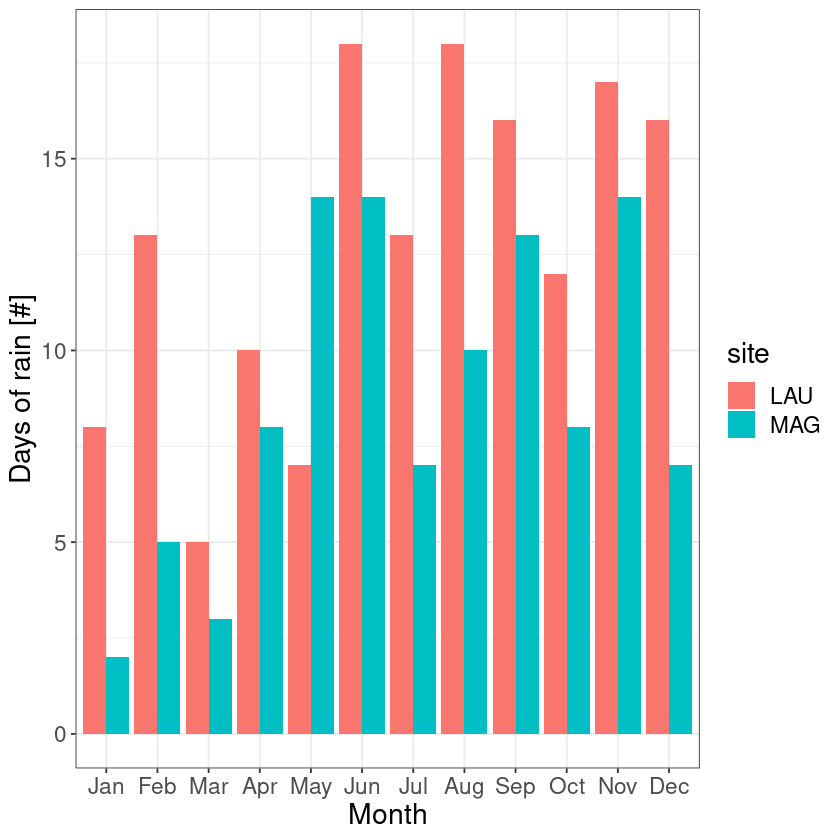

In [24]:
p2 <- monthlyPrec %>%
ggplot + 
geom_col(aes(x=month, y=days.rain, fill=site), position = "dodge")+
labs(x = "Month", y = "Days of rain [#]")+
theme(text = element_text(size = 17))               # Axis text size

p2

dev.print(device=png,
     file="figures/monthly_rain_days.png",
     width=20,height=10,
     units="cm",res=150)

In [25]:
seasonalPrec

site,season,monthly.prec.mean,seasonal.prec.sum,days.rain.sum,days.rain.mean,hours.rain.mean,hours.rain.total,recovery.percent.mean,daily.prec.mean
<chr>,<fct>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
LAU,DJF,68.73333,206.2,37,12.333333,99.66667,99.66667,93.42678,2.275960
LAU,MAM,32.06667,96.2,22,7.333333,45.33333,45.33333,96.66219,1.057348
LAU,JJA,55.46667,166.4,49,16.333333,53.66667,53.66667,100.00000,1.817240
LAU,SON,125.23333,375.7,45,15.000000,102.33333,102.33333,99.12037,4.142222
MAG,DJF,36.53333,109.6,14,4.666667,34.00000,34.00000,100.00000,1.199462
MAG,MAM,64.46667,193.4,25,8.333333,55.33333,55.33333,100.00000,2.109283
MAG,JJA,166.16667,498.5,31,10.333333,41.00000,41.00000,100.00000,5.468566
MAG,SON,182.16667,546.5,35,11.666667,78.66667,78.66667,100.00000,6.004014


png 
  2

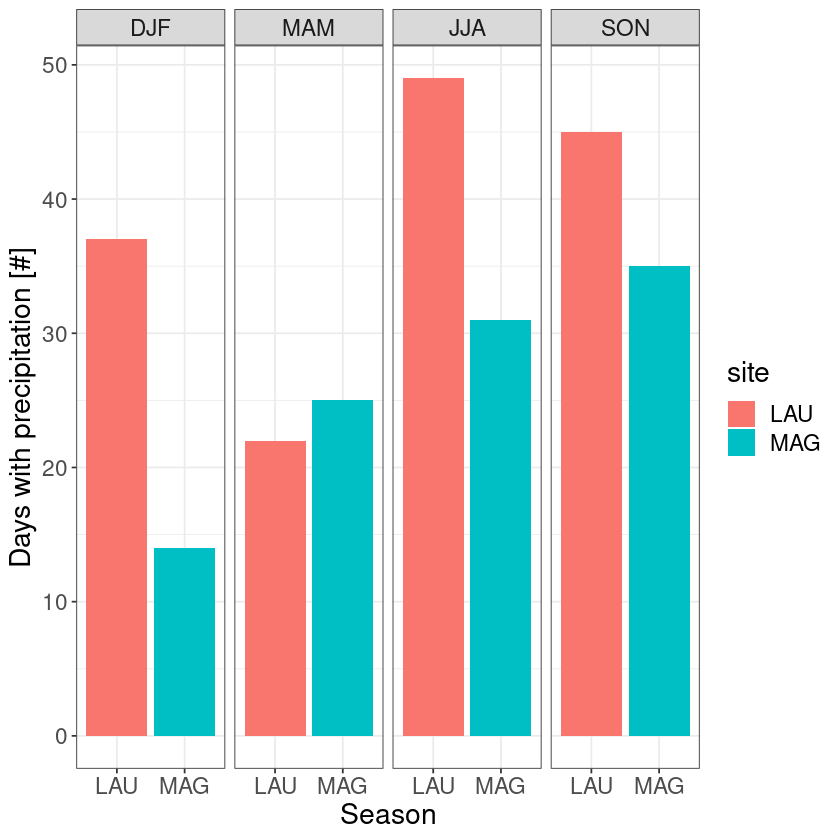

In [39]:
s1 <- seasonalPrec %>%
ggplot + 
facet_grid(col= vars(season))+
geom_col(aes(x=site, y=days.rain.sum, fill=site), position = "dodge")+
labs(x = "Season", y = "Days with precipitation [#]")+
theme(text = element_text(size = 17))  

s1
dev.print(device=png,
     file="figures/seasonal_rain_days.png",
     width=15,height=15,
     units="cm",res=200)

png 
  2

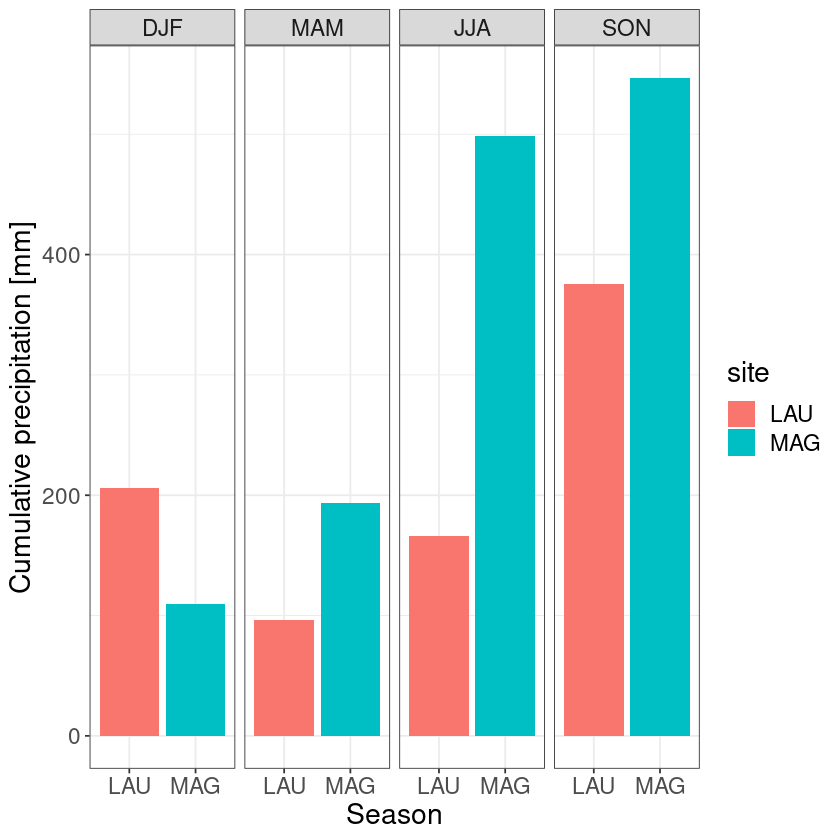

In [40]:
s2 <- seasonalPrec %>%
ggplot + 
facet_grid(col= vars(season))+
geom_col(aes(x=site, y=seasonal.prec.sum, fill=site), position = "dodge")+
labs(x = "Season", y = "Cumulative precipitation [mm]")+
theme(text = element_text(size = 17))  

s2

dev.print(device=png,
     file="figures/seasonal_cumulative_rain.png",
     width=15,height=15,
     units="cm",res=200)